In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import neuron
from neuron import h
import numba
import time, os
import subprocess
import pickle, glob
import scipy
import h5py

from neuron_help_functions import interpolate_field_ofCellSecAndSeg

In [2]:
cell_clone_name = 'L5PC_Clone4' # clone number, 1-5
data_dir = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data'

In [3]:
# (1) Load Efield information in the ROI box
dataPath        = os.path.join(data_dir, 'ROIBox_Evector.npy')
Efield_ROIBox   = np.load(dataPath, allow_pickle=True).item()
print(Efield_ROIBox.keys())
E_position_node = Efield_ROIBox['E_position_node'] # shape=(nodes.nr, 3)
E_vector_node   = Efield_ROIBox['E_vector_node']   # shape=(nodes.nr, 3) 
# (2) Load population neuron information
data_name   = '%s_popCell_sectionAndSegmentCoordinates.npy' % cell_clone_name
data_path   = os.path.join(data_dir, data_name)
popCellInfo = np.load(data_path, allow_pickle=True).item()
sectionCoords_allCells = popCellInfo['popCells_section_coords']['section_coordinates_mid'] # shape = (num_elem, num_section, 3) = (1000,  780, 3)
segmentCoords_allCells = popCellInfo['popCells_segment_coords']['segment_coordinates_mid'] # shape = (num_elem, num_segment, 3) = (1000, 1808, 3)
cell_normals = popCellInfo['cell_normals']
cell_origins = popCellInfo['cell_origins']
num_element  = sectionCoords_allCells.shape[0]
num_section  = sectionCoords_allCells.shape[1]
num_segment  = segmentCoords_allCells.shape[1]

dict_keys(['cube_range', 'E_position_elm', 'E_vector_elm', 'E_position_node', 'E_vector_node'])


In [4]:
%%time
save_name = '%s_popCell_interpolate_Evector_forSectionAndSegment.npy' % cell_clone_name
save_path = os.path.join(data_dir, save_name)
print(save_path)
if not os.path.exists(save_path):
    # ####################################################################### #
    # Run a complete simulation for 1000-cell population field interpolation. #
    # ####################################################################### #
    # Simulation time is about ~1 hour for 1 cpu core.
    # Matlab code is time saved and thus recommended
    E_position, E_vector      = E_position_node, E_vector_node
    popCell_Einterp_section   = np.zeros((num_element, num_section, 3))
    popCell_Einterp_segment   = np.zeros((num_element, num_segment, 3))
    popCell_nearEvector       = [None] * num_element
    popCell_nearNodes         = [None] * num_element
    popCell_nearNodes_indices = [None] * num_element
    for i in range(num_element):
        sectionCoords, segmentCoords = sectionCoords_allCells[i], segmentCoords_allCells[i]
        Einterp_section, Einterp_segment, Evector_near_cell, nodes_near_cell, nodes_near_cell_indices = interpolate_field_ofCellSecAndSeg( \
                           sectionCoords, segmentCoords, E_position, E_vector, method='section', numClosedPoints=10, outlier_threshold=2)
        popCell_Einterp_section[i, :, :] = Einterp_section
        popCell_Einterp_segment[i, :, :] = Einterp_segment
        popCell_nearEvector[i]           = Evector_near_cell
        popCell_nearNodes[i]             = nodes_near_cell
        popCell_nearNodes_indices[i]     = nodes_near_cell_indices
    data = {
        'popCell_Einterp_section': popCell_Einterp_section, # unit - mm
        'popCell_Einterp_segment': popCell_Einterp_segment, # unit - mm
        'popCell_nearEvector': popCell_nearEvector,         # unit - V/m
        'popCell_nearNodes': popCell_nearNodes,             # unit - mm
        'popCell_nearNodes_indices': popCell_nearNodes_indices }
    # save interpolated Efield information for neuron population
    np.save(save_path, data)

C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\L5PC_Clone4_popCell_interpolate_Evector_forSectionAndSegment.npy
Wall time: 1h 11min 47s


In [5]:
if False:
    save_name = '%s_popCell_uniformEfield_bySomaSectionSegment.npy' % cell_clone_name
    save_path = os.path.join(data_dir, save_name)
    print(save_path)
    if not os.path.exists(save_path):
        # ####################################################################################### #
        # Save the uniform Evector based on section/segment mean or soma compartment.
        # ####################################################################################### #
        data_name = '%s_popCell_interpolate_Evector_forSectionAndSegment.npy' % cell_clone_name
        data_path = os.path.join(data_dir, data_name)
        data      = np.load(data_path, allow_pickle=True).item()
        popCell_Einterp_section   = data['popCell_Einterp_section']
        popCell_Einterp_segment   = data['popCell_Einterp_segment']
        popCell_nearEvector       = data['popCell_nearEvector']
        popCell_nearNodes         = data['popCell_nearNodes']
        popCell_nearNodes_indices = data['popCell_nearNodes_indices']
    
        uniformEvector_by_soma        = np.zeros((num_element, 3))
        uniformEvector_by_sectionMean = np.zeros((num_element, 3))
        uniformEvector_by_segmentMean = np.zeros((num_element, 3))
        point_in_or_out_of_cortex     = np.zeros(num_element) + 1
        for i in range(num_element):
            uniformEvector_by_soma[i, :]        = popCell_Einterp_section[i][0, :]
            uniformEvector_by_sectionMean[i, :] = np.mean(popCell_Einterp_section[i], axis=0)
            uniformEvector_by_segmentMean[i, :] = np.mean(popCell_Einterp_segment[i], axis=0)
            if np.dot(popCell_Einterp_section[i][0, :], cell_normals[i, :]) < 0:
                point_in_or_out_of_cortex[i] = -1
        uniformEmagnitude_by_soma        = np.linalg.norm(uniformEvector_by_soma, axis=1)
        uniformEmagnitude_by_sectionMean = np.linalg.norm(uniformEvector_by_sectionMean, axis=1)
        uniformEmagnitude_by_segmentMean = np.linalg.norm(uniformEvector_by_segmentMean, axis=1)
        data = {
            'uniformEvector_by_soma': uniformEvector_by_soma,
            'uniformEmagnitude_by_soma': uniformEmagnitude_by_soma,
            'uniformEvector_by_sectionMean': uniformEvector_by_sectionMean,
            'uniformEmagnitude_by_sectionMean': uniformEmagnitude_by_sectionMean,
            'uniformEvector_by_segmentMean': uniformEvector_by_segmentMean,
            'uniformEmagnitude_by_segmentMean': uniformEmagnitude_by_segmentMean,
            'point_in_or_out_of_cortex': point_in_or_out_of_cortex,
            'cell_normals': cell_normals,
            'cell_origins': cell_origins, 
            'num_element': num_element
        }
        # save uniform Evector for each cell in the population
        scipy.io.savemat(save_path, data)

In [6]:
data_name = '%s_popCell_interpolate_Evector_forSectionAndSegment.npy' % cell_clone_name
data_path = os.path.join(data_dir, data_name)
data      = np.load(data_path, allow_pickle=True).item()
indices = [475, 483, 531, 474, 529, 481, 473, 480, 472, 528]
popCell_Einterp_section   = data['popCell_Einterp_section']
popCell_Einterp_segment   = data['popCell_Einterp_segment']
popCell_nearEvector       = data['popCell_nearEvector']
popCell_nearNodes         = data['popCell_nearNodes']
popCell_nearNodes_indices = data['popCell_nearNodes_indices']

data_name   = '%s_popCell_sectionAndSegmentCoordinates.npy' % cell_clone_name
data_path   = os.path.join(data_dir, data_name)
popCellInfo = np.load(data_path, allow_pickle=True).item()
sectionCoords_start = popCellInfo['popCells_section_coords']['section_coordinates_start'] # shape = (num_elem, num_section, 3) = (1000,  780, 3)
sectionCoords_mid   = popCellInfo['popCells_section_coords']['section_coordinates_mid']
sectionCoords_end   = popCellInfo['popCells_section_coords']['section_coordinates_end']

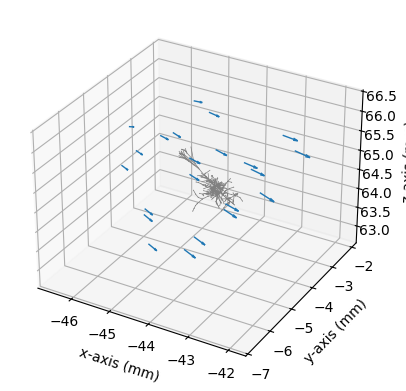

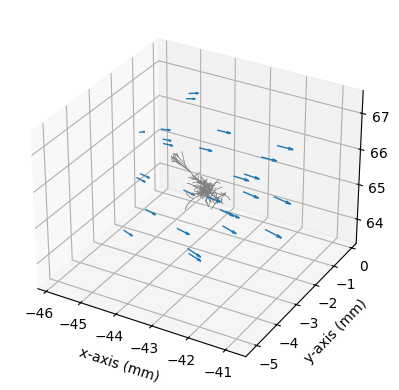

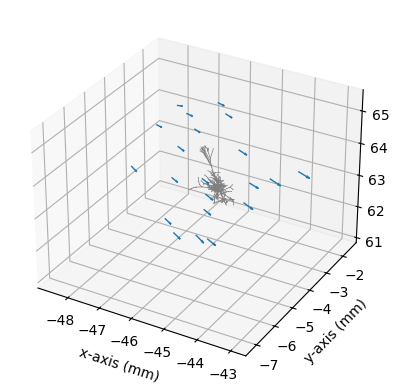

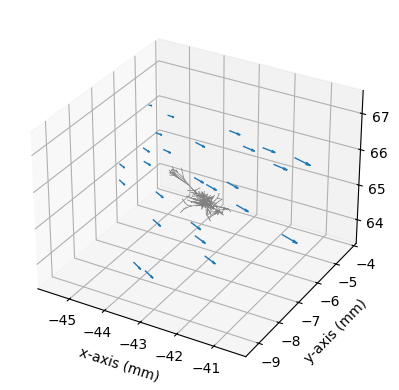

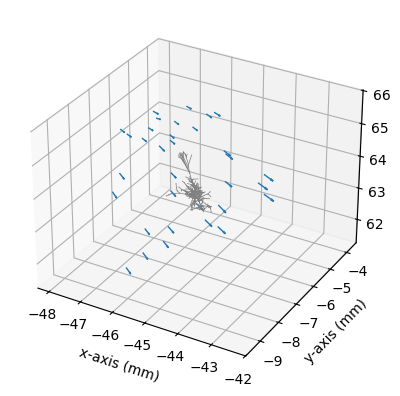

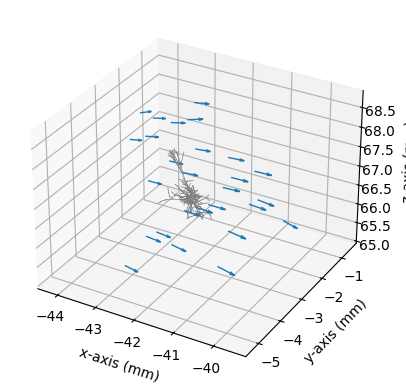

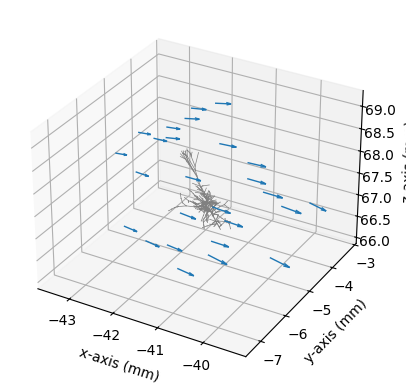

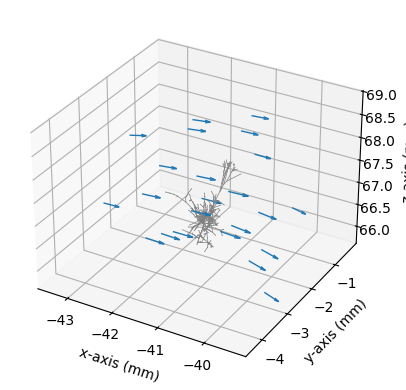

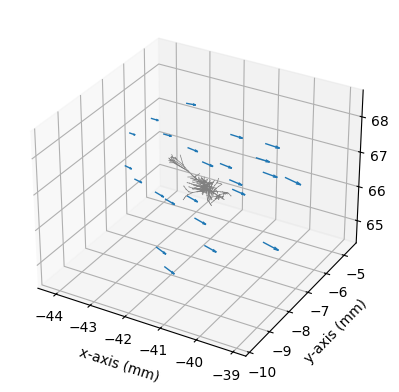

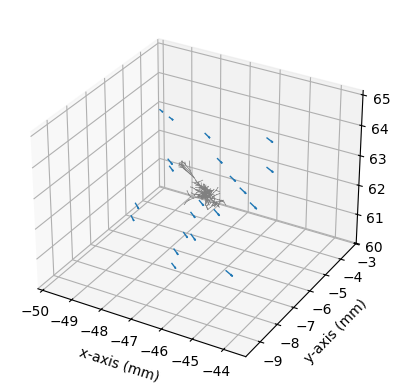

In [7]:
# for i in [473]:
for i in indices:
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    tempPosition  = popCell_nearNodes[i]
    tempDirection = np.array([popCell_nearEvector[i][j]/np.linalg.norm(popCell_nearEvector[i][j]) for j in range(popCell_nearEvector[i].shape[0])])
    tempLength    = np.linalg.norm(popCell_nearEvector[i], axis=1) * 1.
    for j in range(sectionCoords_start.shape[1]):
        ax.plot([sectionCoords_start[i][j][0], sectionCoords_end[i][j][0]],
                [sectionCoords_start[i][j][1], sectionCoords_end[i][j][1]],
                [sectionCoords_start[i][j][2], sectionCoords_end[i][j][2]], lw=0.5, color='gray', zorder=5
               )
    for k in range(popCell_nearEvector[i].shape[0]):
        ax.quiver(tempPosition[k,0], tempPosition[k,1], tempPosition[k,2], \
                  tempDirection[k,0], tempDirection[k,1], tempDirection[k,2], length=tempLength[k], lw=1)
    
    ax.axis('equal')
    # ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel('x-axis (mm)', fontsize=10, labelpad=1)
    ax.set_ylabel('y-axis (mm)', fontsize=10, labelpad=1)
    ax.set_zlabel('z-axis (mm)', fontsize=10, labelpad=1)
    ax.tick_params(pad=0)
    plt.tight_layout()
    # ax.view_init(elev=0, azim=90)
    # break